## **Vectorbt Exploration and 3 EMA Strategies Backtesting**

In [1]:
import vectorbt as vbt
from itertools import combinations, product
from vectorbt.portfolio.enums import SizeType
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import pytz
from dateutil.parser import parse
import ipywidgets as widgets
from copy import deepcopy
from tqdm import tqdm
import imageio
from IPython import display
import plotly.graph_objects as go
import itertools
import dateparser
import gc

In [2]:
seed = 42
symbol = 'BTC-USD'
metric = 'total_return'

# for less than 1D frequency
# start_date = datetime.now(pytz.utc) - timedelta(days=59)  # 60 days ago from today
# end_date = datetime.now(pytz.utc)  # today's date
# time_buffer = timedelta(minutes=30)  # buffer before to pre-calculate BB, best to set to max window
# freq = '15m'

start_date = datetime(2021, 11, 15, tzinfo=pytz.utc)  # time period for analysis, must be timezone-aware
end_date = datetime(2024, 11, 15, tzinfo=pytz.utc)
time_buffer = timedelta(days=15)  # buffer before to pre-calculate SMA/EMA, best to set to max window
freq = '1D'

vbt.settings.portfolio['init_cash'] = 10000.  # 100$
vbt.settings.portfolio['fees'] = 0.0025  # 0.25%
vbt.settings.portfolio['slippage'] = 0.0025  # 0.25%

In [3]:
cols = ['Open', 'High', 'Low', 'Close', 'Volume']
ohlcv_wbuf = vbt.YFData.download(symbol, start=start_date-time_buffer, end=end_date, interval=freq).get(cols)

ohlcv_wbuf = ohlcv_wbuf.astype(np.float64)
    
print(ohlcv_wbuf.shape)
print(ohlcv_wbuf.columns)

(1111, 5)
Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


In [4]:
ohlcv_wbuf

,Open,High,Low,Close,Volume
Date,,,,,
2021-10-31 00:00:00+00:00,61850.488281,62406.171875,60074.328125,61318.957031,3.224120e+10
2021-11-01 00:00:00+00:00,61320.449219,62419.003906,59695.183594,61004.406250,3.615057e+10
2021-11-02 00:00:00+00:00,60963.253906,64242.792969,60673.054688,63226.402344,3.774667e+10
2021-11-03 00:00:00+00:00,63254.335938,63516.937500,61184.238281,62970.046875,3.612473e+10
2021-11-04 00:00:00+00:00,62941.804688,63123.289062,60799.664062,61452.230469,3.261585e+10
...,...,...,...,...,...
2024-11-10 00:00:00+00:00,76775.546875,81474.421875,76565.429688,80474.187500,8.257059e+10
2024-11-11 00:00:00+00:00,80471.414062,89604.500000,80283.250000,88701.484375,1.179668e+11
2024-11-12 00:00:00+00:00,88705.562500,89956.882812,85155.109375,87955.812500,1.336733e+11


In [5]:
# Create a copy of data without time buffer
wobuf_mask = (ohlcv_wbuf.index >= start_date) & (ohlcv_wbuf.index <= end_date) # mask without buffer

ohlcv = ohlcv_wbuf.loc[wobuf_mask, :]

print(ohlcv.shape)

(1096, 5)


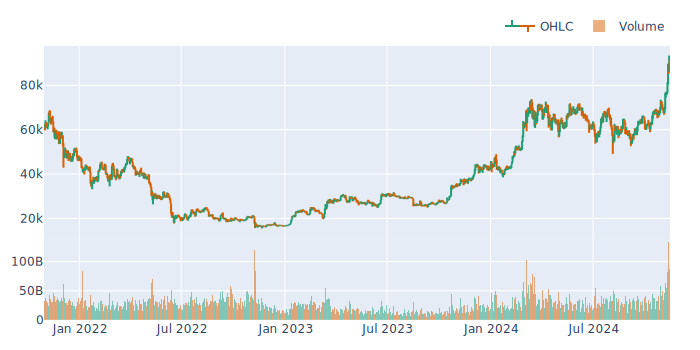

In [6]:
ohlcv_wbuf.vbt.ohlcv.plot().show_svg() 

In [19]:
rsi_window = 10
fast_ema_window = 5
ema_window = 30
slow_ema = 100

bbands = vbt.BBANDS.run(ohlcv_wbuf['Close'])
fast_ema = vbt.MA.run(ohlcv_wbuf['Close'], window=fast_ema_window, short_name='EMA', ewm=True)
ema = vbt.MA.run(ohlcv_wbuf['Close'], window=ema_window, short_name='EMA', ewm=True)
slow_ema = vbt.MA.run(ohlcv_wbuf['Close'], window=slow_ema, short_name='EMA', ewm=True)
rsi = vbt.RSI.run(ohlcv_wbuf['Close'], window=rsi_window)
stoch = vbt.STOCH.run(ohlcv_wbuf['High'], ohlcv_wbuf['Low'], ohlcv_wbuf['Close'])

In [21]:
mask = (ohlcv_wbuf.index >= start_date + timedelta(days=55)) & (ohlcv_wbuf.index <= end_date)
filtered_dates = ohlcv_wbuf.index[mask]
filtered_close = ohlcv_wbuf['Close'][mask]
filtered_bbands_upper = bbands.upper[mask]
filtered_bbands_middle = bbands.middle[mask]
filtered_bbands_lower = bbands.lower[mask]
filtered_ema = ema[mask].ma
filtered_fast_ema = fast_ema[mask].ma
filtered_slow_ema = slow_ema[mask].ma
filtered_rsi = rsi[mask].rsi

# Create a Figure object for Bollinger Bands
fig1 = go.Figure()

# Add Bollinger Bands
fig1.add_trace(go.Scatter(x=filtered_dates, y=filtered_bbands_upper, name='Upper BB', line=dict(color='gray', dash='dash')))
fig1.add_trace(go.Scatter(x=filtered_dates, y=filtered_bbands_middle, name='Middle BB', line=dict(color='gray')))
fig1.add_trace(go.Scatter(x=filtered_dates, y=filtered_bbands_lower, name='Lower BB', line=dict(color='gray', dash='dash')))

# Add EMA and Close Price
fig1.add_trace(go.Scatter(x=filtered_dates, y=filtered_ema, name='EMA', line=dict(color='blue')))
fig1.add_trace(go.Scatter(x=filtered_dates, y=filtered_fast_ema, name='Fast EMA', line=dict(color='purple')))
fig1.add_trace(go.Scatter(x=filtered_dates, y=filtered_slow_ema, name='Slow EMA', line=dict(color='yellow')))
fig1.add_trace(go.Scatter(x=filtered_dates, y=filtered_close, name='Close Price', line=dict(color='black')))

# Update layout
fig1.update_layout(title='Bollinger Bands with EMA', xaxis_title='Date', yaxis_title='Price')
fig1.show()

# Create RSI plot
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=filtered_dates, y=filtered_rsi, name='RSI'))

# Add RSI reference lines
fig2.add_hline(y=70, line_dash="dash", line_color="red")
fig2.add_hline(y=30, line_dash="dash", line_color="green")

# Update layout
fig2.update_layout(title='Relative Strength Index (RSI)', xaxis_title='Date', yaxis_title='RSI')
fig2.show()

In [22]:
close = ohlcv_wbuf['Close']
# upper_band = bbands.upper
# lower_band = bbands.lower

# stoch_signal = (stoch.percent_k < 20) & (stoch.percent_d < 20)
slow_ema_signal = (fast_ema.ma > slow_ema.ma) & (ema.ma > slow_ema.ma) 

buy_signal =  (fast_ema.ma >= ema.ma) & slow_ema_signal
# (close <= lower_band) &
# & (rsi.rsi <= 30) 
# & (close >= ema.ma)
sell_signal =  (fast_ema.ma <= ema.ma) 
# (close >= upper_band) &
# & (rsi.rsi >= 70) 
# & (close <= ema.ma)

In [23]:
# Define the percentage of equity to use for each position (e.g., 10% of total equity)
# percentage_of_equity = 0.1  # 10%

portfolio_percent = vbt.Portfolio.from_signals(
    ohlcv_wbuf['Close'],
    entries=buy_signal,
    exits=sell_signal,
    # size=percentage_of_equity,
    # size_type=SizeType.Percent,
    freq=freq  
)

# Print performance metrics
print(portfolio_percent.stats())

Start                         2021-10-31 00:00:00+00:00
End                           2024-11-14 00:00:00+00:00
Period                               1111 days 00:00:00
Start Value                                     10000.0
End Value                                  25405.976676
Total Return [%]                             154.059767
Benchmark Return [%]                          42.289487
Max Gross Exposure [%]                            100.0
Total Fees Paid                              786.278467
Max Drawdown [%]                              28.694183
Max Drawdown Duration                 242 days 00:00:00
Total Trades                                         11
Total Closed Trades                                  10
Total Open Trades                                     1
Open Trade PnL                               6913.02573
Win Rate [%]                                       50.0
Best Trade [%]                                47.225099
Worst Trade [%]                               -8

In [24]:
print(portfolio_percent.trades.records)
portfolio_percent.trades.plot()

    id  col      size  entry_idx   entry_price  entry_fees  exit_idx  \
0    0    0  0.471868        445  21139.509951   24.937656       489   
1    1    0  0.422002        499  24807.939404   26.172472       539   
2    2    0  0.391119        543  29547.471577   28.891426       554   
3    3    0  0.387114        576  27771.605483   26.876955       577   
4    4    0  0.368274        597  28398.307002   26.145874       631   
5    5    0  0.358393        719  29757.156592   26.661927       806   
6    6    0  0.351187        821  43059.990898   37.805305       895   
7    7    0  0.334859        927  66433.160918   55.614375       957   
8    8    0  0.331947        996  66092.491055   54.847963      1006   
9    9    0  0.306786       1062  65955.140723   50.585347      1074   
10  10    0  0.291185       1077  63351.005996   46.117085      1110   

      exit_price  exit_fees          pnl    return  direction  status  \
0   22297.466235  26.303663   495.161420  0.049640          0 

FigureWidget({
    'data': [{'line': {'color': '#1f77b4'},
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': '5ad3101e-160d-4c90-b6fc-c598f2bfd998',
              'x': array([datetime.datetime(2021, 10, 31, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2021, 11, 1, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2021, 11, 2, 0, 0, tzinfo=datetime.timezone.utc), ...,
                          datetime.datetime(2024, 11, 12, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2024, 11, 13, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2024, 11, 14, 0, 0, tzinfo=datetime.timezone.utc)],
                         dtype=object),
              'y': array([61318.95703125, 61004.40625   , 63226.40234375, ..., 87955.8125    ,
                          90584.1640625 , 87250.4296875 ])},
            

### **Optimize Fast and Medium MA Parameters for best entries**
- Perform Walk Forward Optimzation to search for parameters

use term slow ma for this medium ma for this section

In [25]:
price = ohlcv_wbuf['Close']

In [111]:
split_kwargs = dict(
    n=10, 
    window_len=365 * 2, 
    set_lens=(180,), 
    left_to_right=False
)  # 30 windows, each 2 years long, reserve 180 days for test
pf_kwargs = dict(
    direction='both',  # long and short
    freq='d'
)
windows = np.arange(5, 50)

In [112]:
def roll_in_and_out_samples(price, **kwargs):
    return price.vbt.rolling_split(**kwargs)

In [113]:
roll_in_and_out_samples(price.dropna(), **split_kwargs, plot=True, trace_names=['in-sample', 'out-sample'])

c:\Users\pond\anaconda3\Lib\site-packages\jupyter_client\session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant: nan
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

c:\Users\pond\anaconda3\Lib\site-packages\jupyter_client\session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant: nan
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



FigureWidget({
    'data': [{'colorscale': [[0.0, '#1f77b4'], [1.0, '#1f77b4']],
              'hoverongaps': False,
              'name': 'in-sample',
              'showlegend': True,
              'showscale': False,
              'type': 'heatmap',
              'uid': '2f2b480b-e7ca-4415-97b1-bbf1c5648e9a',
              'x': array([datetime.datetime(2021, 10, 31, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2021, 11, 1, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2021, 11, 2, 0, 0, tzinfo=datetime.timezone.utc), ...,
                          datetime.datetime(2024, 11, 12, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2024, 11, 13, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2024, 11, 14, 0, 0, tzinfo=datetime.timezone.utc)],
                         dtype=object),
              'y': array([9, 8, 7, 6, 5, 4, 3, 2, 1, 0], dtype=int64),
 

In [114]:
(in_price, in_indexes), (out_price, out_indexes) = roll_in_and_out_samples(price, **split_kwargs)

print(in_price.shape, len(in_indexes))  # in-sample
print(out_price.shape, len(out_indexes))  # out-sample

(550, 10) 10
(180, 10) 10


In [115]:
def simulate_holding(price, **kwargs):
    pf = vbt.Portfolio.from_holding(price, **kwargs)
    return pf.sharpe_ratio()

In [116]:
in_hold_sharpe = simulate_holding(in_price, **pf_kwargs)

print(in_hold_sharpe)

split_idx
0   -0.513824
1   -0.476160
2    0.026164
3   -0.176420
4   -0.172647
5    0.505543
6    1.325419
7    1.441835
8    1.913600
9    2.181657
Name: sharpe_ratio, dtype: float64


#### **Search for fast and slow MA that result max Sharpe ratio of each period**

##### In-sample search

In [117]:
def simulate_all_params(price, windows, **kwargs):
    fast_ma, slow_ma = vbt.MA.run_combs(price, windows, r=2, short_names=['fast', 'slow'], ewm=True)
    entries = fast_ma.ma_crossed_above(slow_ma)
    exits = fast_ma.ma_crossed_below(slow_ma)
    pf = vbt.Portfolio.from_signals(price, entries, exits, **kwargs)
    return pf.sharpe_ratio()

In [118]:
# Simulate all params for in-sample ranges
in_sharpe = simulate_all_params(in_price, windows, **pf_kwargs)

print(in_sharpe)

fast_window  fast_ewm  slow_window  slow_ewm  split_idx
5            True      6            True      0           -0.416341
                                              1           -0.670553
                                              2           -0.764117
                                              3           -0.436799
                                              4           -0.973743
                                                             ...   
48           True      49           True      5            0.088687
                                              6            0.191568
                                              7            0.137674
                                              8            1.028613
                                              9            0.737888
Name: sharpe_ratio, Length: 9900, dtype: float64


In [119]:
def get_best_index(performance, higher_better=True):
    if higher_better:
        return performance[performance.groupby('split_idx').idxmax()].index
    return performance[performance.groupby('split_idx').idxmin()].index


in_best_index = get_best_index(in_sharpe)

print(in_best_index)

MultiIndex([(45, True, 49, True, 0),
            (38, True, 46, True, 1),
            (42, True, 49, True, 2),
            (35, True, 49, True, 3),
            (19, True, 22, True, 4),
            (35, True, 49, True, 5),
            ( 5, True, 43, True, 6),
            ( 7, True, 38, True, 7),
            (19, True, 48, True, 8),
            ( 7, True, 37, True, 9)],
           names=['fast_window', 'fast_ewm', 'slow_window', 'slow_ewm', 'split_idx'])


In [120]:
def get_best_params(best_index, level_name):
    return best_index.get_level_values(level_name).to_numpy()

in_best_fast_windows = get_best_params(in_best_index, 'fast_window')
in_best_slow_windows = get_best_params(in_best_index, 'slow_window')
in_best_window_pairs = np.array(list(zip(in_best_fast_windows, in_best_slow_windows)))

print(in_best_window_pairs)

[[45 49]
 [38 46]
 [42 49]
 [35 49]
 [19 22]
 [35 49]
 [ 5 43]
 [ 7 38]
 [19 48]
 [ 7 37]]


In [121]:
# pd.DataFrame(in_sharpe[in_sharpe.index.get_level_values('split_idx') == 13]).sort_values(by='sharpe_ratio')

In [122]:
# pd.DataFrame(in_best_window_pairs, columns=['fast_window', 'slow_window']).vbt.plot().show_svg()

##### Holding Sharpe ratio in each period

In [123]:
out_hold_sharpe = simulate_holding(out_price, **pf_kwargs)

print(out_hold_sharpe)

split_idx
0    1.129754
1    2.644360
2    1.645587
3    4.118206
4    3.075236
5    2.196404
6    1.374454
7    0.860431
8   -0.297791
9    1.323256
Name: sharpe_ratio, dtype: float64


##### Out-sample Sharpe search

In [124]:
# Simulate all params for out-sample ranges
out_sharpe = simulate_all_params(out_price, windows, **pf_kwargs)

print(out_sharpe)

fast_window  fast_ewm  slow_window  slow_ewm  split_idx
5            True      6            True      0           -0.535679
                                              1           -0.435963
                                              2           -0.854674
                                              3            1.164174
                                              4           -0.027866
                                                             ...   
48           True      49           True      5                 inf
                                              6            0.967742
                                              7           -1.671423
                                              8           -1.523669
                                              9            2.141681
Name: sharpe_ratio, Length: 9900, dtype: float64


In [125]:
def simulate_best_params(price, best_fast_windows, best_slow_windows, **kwargs):
    fast_ma = vbt.MA.run(price, window=best_fast_windows, per_column=True, ewm=True)
    slow_ma = vbt.MA.run(price, window=best_slow_windows, per_column=True, ewm=True)
    entries = fast_ma.ma_crossed_above(slow_ma)
    exits = fast_ma.ma_crossed_below(slow_ma)
    pf = vbt.Portfolio.from_signals(price, entries, exits, **kwargs)
    return pf.sharpe_ratio()


# Use best params from in-sample ranges and simulate them for out-sample ranges
out_test_sharpe = simulate_best_params(out_price, in_best_fast_windows, in_best_slow_windows, **pf_kwargs)

print(out_test_sharpe)

ma_window  ma_window  ma_ewm  split_idx
45         49         True    0           -0.521226
38         46         True    1            1.739740
42         49         True    2            1.971457
35         49         True    3                 inf
19         22         True    4            1.783110
35         49         True    5           -0.744871
5          43         True    6            0.103408
7          38         True    7           -0.540295
19         48         True    8           -1.692312
7          37         True    9            0.050395
Name: sharpe_ratio, dtype: float64


**Best index of out-sample**

In [127]:
out_best_index = get_best_index(out_sharpe)
out_best_index

MultiIndex([(11, True, 16, True, 0),
            (11, True, 16, True, 1),
            (11, True, 16, True, 2),
            (18, True, 49, True, 3),
            (19, True, 49, True, 4),
            (38, True, 48, True, 5),
            (14, True, 17, True, 6),
            ( 8, True, 28, True, 7),
            ( 5, True, 12, True, 8),
            (45, True, 48, True, 9)],
           names=['fast_window', 'fast_ewm', 'slow_window', 'slow_ewm', 'split_idx'])

In [128]:
out_sharpe[out_best_index]

fast_window  fast_ewm  slow_window  slow_ewm  split_idx
11           True      16           True      0            2.920033
                                              1            3.350856
                                              2            3.063690
18           True      49           True      3                 inf
19           True      49           True      4                 inf
38           True      48           True      5                 inf
14           True      17           True      6            2.211775
8            True      28           True      7           -0.101506
5            True      12           True      8            0.737039
45           True      48           True      9            2.152476
Name: sharpe_ratio, dtype: float64

In [ ]:
def simulate_all_params(price, windows, **kwargs):
    fast_ma, slow_ma = vbt.MA.run_combs(price, windows, r=2, short_names=['fast', 'slow'], ewm=True)
    entries = fast_ma.ma_crossed_above(slow_ma)
    exits = fast_ma.ma_crossed_below(slow_ma)
    pf = vbt.Portfolio.from_signals(price, entries, exits, **kwargs)
    return pf.sharpe_ratio()

In [80]:
# pd.DataFrame(out_sharpe[out_sharpe.index.get_level_values('split_idx') == 14]).sort_values(by='sharpe_ratio')

In [81]:
cv_results_df = pd.DataFrame({
    'in_sample_hold': in_hold_sharpe.values,
    'in_sample_median': in_sharpe.groupby('split_idx').median().values,
    'in_sample_best': in_sharpe[in_best_index].values,
    'out_sample_hold': out_hold_sharpe.values,
    'out_sample_median': out_sharpe.groupby('split_idx').median().values,
    'out_sample_test': out_test_sharpe.values
})

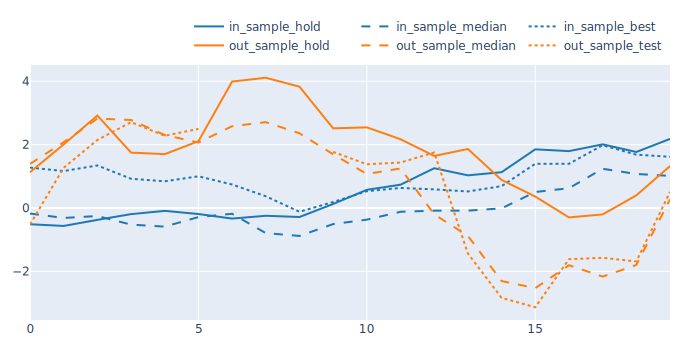

In [82]:
color_schema = vbt.settings['plotting']['color_schema']

cv_results_df.vbt.plot(
    trace_kwargs=[
        dict(line_color=color_schema['blue']),
        dict(line_color=color_schema['blue'], line_dash='dash'),
        dict(line_color=color_schema['blue'], line_dash='dot'),
        dict(line_color=color_schema['orange']),
        dict(line_color=color_schema['orange'], line_dash='dash'),
        dict(line_color=color_schema['orange'], line_dash='dot')
    ]
).show_svg()

### **Combined with Macro Trend (Slow EMA)**

- slow (macro trend MA) need to be optimized too 

In [146]:
best_param_overtime = simulate_all_params(ohlcv_wbuf['Close'], windows)

# best_fast_windows = get_best_params(best_index_overtime, 'fast_window')
# best_slow_windows = get_best_params(best_index_overtime, 'slow_window')
# best_window_pairs = np.array(list(zip(best_fast_windows, best_slow_windows)))

# best_window_pairs (the overfit one)
pd.DataFrame(best_param_overtime).sort_values(by='sharpe_ratio')

sharpe_ratio
fast_window fast_ewm slow_window slow_ewm              
5           True     6           True         -0.120397
                     7           True          0.015760
8           True     13          True          0.111954
11          True     12          True          0.120916
9           True     12          True          0.130234
...                                                 ...
40          True     43          True          0.891179
41          True     42          True          0.891179
39          True     44          True          0.891179
45          True     49          True          0.910406
46          True     48          True          0.910406

[990 rows x 1 columns]

In [241]:
# fast_ema_window = 5
# ema_window = 32
fast_ema_window = 45
ema_window = 48
slow_ema = 150

fast_ema = vbt.MA.run(ohlcv_wbuf['Close'], window=fast_ema_window, short_name='EMA', ewm=True)
med_ema = vbt.MA.run(ohlcv_wbuf['Close'], window=ema_window, short_name='EMA', ewm=True)
slow_ema = vbt.MA.run(ohlcv_wbuf['Close'], window=slow_ema, short_name='EMA', ewm=True)

In [242]:
slow_ema_signal = (fast_ema.ma > slow_ema.ma) & (med_ema.ma > slow_ema.ma) 
slow_ema_sell_signal = (fast_ema.ma < slow_ema.ma) & (med_ema.ma < slow_ema.ma) 
buy_signal =  (fast_ema.ma > med_ema.ma) & slow_ema_signal
buy_exit_signal =  (fast_ema.ma < med_ema.ma) 

In [243]:
portfolio_percent = vbt.Portfolio.from_signals(
    ohlcv_wbuf['Close'],
    entries=buy_signal,
    exits=buy_exit_signal,
    freq=freq  
)

# Print performance metrics
print(portfolio_percent.stats())

Start                         2021-10-31 00:00:00+00:00
End                           2024-11-14 00:00:00+00:00
Period                               1111 days 00:00:00
Start Value                                     10000.0
End Value                                  22548.987818
Total Return [%]                             125.489878
Benchmark Return [%]                          42.289487
Max Gross Exposure [%]                            100.0
Total Fees Paid                              314.714263
Max Drawdown [%]                              35.547216
Max Drawdown Duration                 246 days 00:00:00
Total Trades                                          5
Total Closed Trades                                   4
Total Open Trades                                     1
Open Trade PnL                               5460.93766
Win Rate [%]                                       50.0
Best Trade [%]                               112.649418
Worst Trade [%]                               -1

In [244]:
portfolio_percent.trades.plot()

FigureWidget({
    'data': [{'line': {'color': '#1f77b4'},
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'c7a5a10c-a683-4772-a525-806df7be73a4',
              'x': array([datetime.datetime(2021, 10, 31, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2021, 11, 1, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2021, 11, 2, 0, 0, tzinfo=datetime.timezone.utc), ...,
                          datetime.datetime(2024, 11, 12, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2024, 11, 13, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2024, 11, 14, 0, 0, tzinfo=datetime.timezone.utc)],
                         dtype=object),
              'y': array([61318.95703125, 61004.40625   , 63226.40234375, ..., 87955.8125    ,
                          90584.1640625 , 87250.4296875 ])},
            

#### Try Combine with Short signal

In [245]:
sell_signal = (fast_ema.ma < med_ema.ma) & slow_ema_sell_signal
sell_exit_signal = (fast_ema.ma > med_ema.ma) 

In [246]:
portfolio_percent_wshort = vbt.Portfolio.from_signals(
    ohlcv_wbuf['Close'],
    entries=buy_signal,
    exits=sell_signal,
    short_entries=sell_signal,
    short_exits=sell_exit_signal,
    freq=freq  
)

# Print performance metrics
print(portfolio_percent_wshort.stats())

Start                         2021-10-31 00:00:00+00:00
End                           2024-11-14 00:00:00+00:00
Period                               1111 days 00:00:00
Start Value                                     10000.0
End Value                                  30242.151331
Total Return [%]                             202.421513
Benchmark Return [%]                          42.289487
Max Gross Exposure [%]                            100.0
Total Fees Paid                              503.563473
Max Drawdown [%]                              40.123561
Max Drawdown Duration                 246 days 00:00:00
Total Trades                                          6
Total Closed Trades                                   5
Total Open Trades                                     1
Open Trade PnL                              7324.076115
Win Rate [%]                                       60.0
Best Trade [%]                                97.860584
Worst Trade [%]                               -1

In [247]:
portfolio_percent_wshort.trades.plot()

FigureWidget({
    'data': [{'line': {'color': '#1f77b4'},
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': '7dd8e136-69a4-4fa1-b0d7-9ceddeaddfd4',
              'x': array([datetime.datetime(2021, 10, 31, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2021, 11, 1, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2021, 11, 2, 0, 0, tzinfo=datetime.timezone.utc), ...,
                          datetime.datetime(2024, 11, 12, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2024, 11, 13, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2024, 11, 14, 0, 0, tzinfo=datetime.timezone.utc)],
                         dtype=object),
              'y': array([61318.95703125, 61004.40625   , 63226.40234375, ..., 87955.8125    ,
                          90584.1640625 , 87250.4296875 ])},
            

#### Holding Performance in this period 

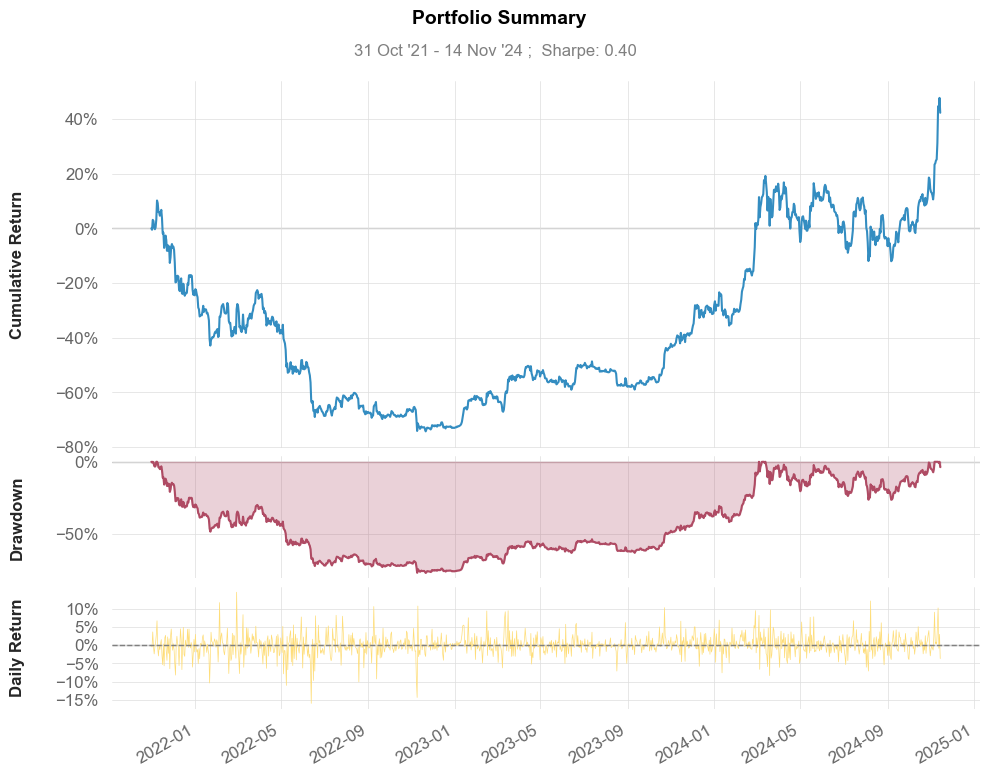

In [248]:
returns = ohlcv_wbuf['Close'].vbt.to_returns()
returns.vbt.returns.qs.plot_snapshot()

#### Comparison with 3 EMA Strategies with sharpe ratio

In [249]:
pf_hold = vbt.Portfolio.from_holding(ohlcv_wbuf['Close'])

# Calculate Sharpe ratios
hold_sharpe_ratio = pf_hold.sharpe_ratio()
strategy_sharpe_ratio = portfolio_percent.sharpe_ratio()
wshort_sharpe_ratio = portfolio_percent_wshort.sharpe_ratio()

hold_sharpe_ratio_text = f"{hold_sharpe_ratio:.3f}"
strategy_sharpe_ratio_text = f"{strategy_sharpe_ratio:.3f}"
wshort_sharpe_ratio_text = f"{wshort_sharpe_ratio:.3f}"

# Create a scatter plot
fig = go.Figure()

# Add points for each Sharpe ratio
fig.add_trace(go.Scatter(
    x=['Hold', '3 EMA Strategy', '3 EMA Strategy /w Short'], 
    y=[hold_sharpe_ratio, strategy_sharpe_ratio, wshort_sharpe_ratio],
    mode='markers+text',  # Show markers and text
    marker=dict(size=10, color=['blue', 'orange', 'yellow']),  # Customize marker size and color
    text=[hold_sharpe_ratio_text, strategy_sharpe_ratio_text, wshort_sharpe_ratio_text],  # Display the value on the markers
    textposition='top center'  # Position the text above the markers
))

# Update layout with adjusted y-axis range for better spacing
fig.update_layout(
    title='Sharpe Ratio',
    xaxis_title='Strategy',
    yaxis_title='Sharpe Ratio',
    height=500,
    yaxis=dict(range=[min(hold_sharpe_ratio, strategy_sharpe_ratio, wshort_sharpe_ratio) - 0.2,\
                     max(hold_sharpe_ratio, strategy_sharpe_ratio, wshort_sharpe_ratio) + 0.2])
)

# Show the plot
fig.show()

#### **Further Improvement**
- Combination search for 3 parameters
- the parameters seem overfit so it maybe better if optimize each period and specify period for optmizing new parameters
    - Macro trend tend to be the noise filtering EMA and then optimize the fast and medium over time
    - Optmize the parameter set for each market sentiment (when bearish use 1 set when bullish use 1 set)
- each parameter seem work best in different market behaviour bullish phase(high volatility) some paramters may fit more
    - consider combine with other valatility measurements